In [3]:
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np

from qiskit import Aer, QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, assemble
from qiskit.utils import QuantumInstance
from qiskit_ionq import IonQProvider
from qiskit.extensions import UnitaryGate
from qiskit.visualization import plot_histogram

In [4]:
ionq_provider = IonQProvider('r4o7WWWCZetVsf6TgrZ95PAF4PcpATmx')
ionq_provider.backends()
aer_backend = Aer.get_backend("aer_simulator")
ionq_backend_sim = ionq_provider.get_backend('ionq_simulator') 
ionq_backend= ionq_provider.get_backend('ionq_qpu')

In [5]:
ionq_provider.backends()

[<IonQSimulatorBackend('ionq_simulator')>, <IonQQPUBackend('ionq_qpu')>]

# Task 7

4


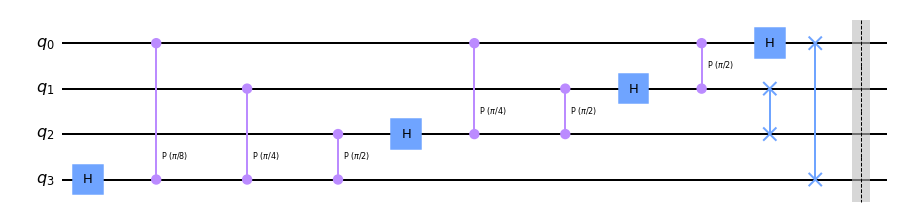

In [6]:
def qft_rot(circuit, n):
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(np.pi/2**(n-qubit), qubit, n)
    qft_rot(circuit, n)
    
def swap_registers(circuit, n):
    print(n)
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rot(circuit, n)
    swap_registers(circuit, n)
    return circuit

# Let's see how it looks:
qc = QuantumCircuit(4)
qft(qc,4)
qc.barrier()
qc.draw('mpl')




4


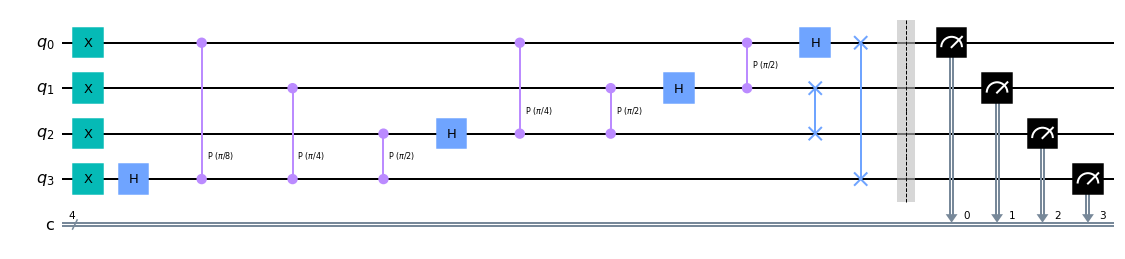

In [11]:
qc = QuantumCircuit(4,4)
qc.x(range(4))
qft(qc,4) 
qc.barrier()
qc.measure(range(4),range(4))
qc.draw('mpl')





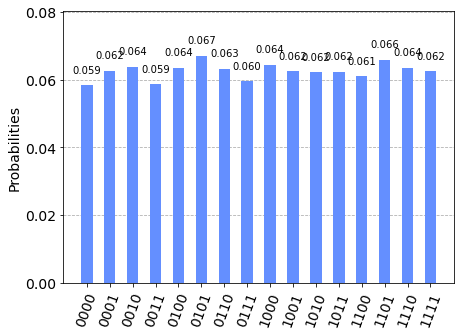

In [12]:
aer_qc=transpile(qc,aer_backend)
shots=10000
aer_obj = assemble(aer_qc, shots=shots)
job_aer = aer_backend.run(aer_obj)
aer_result=job_aer.result()
aer_pros = aer_result.get_counts()
plot_histogram(aer_pros)




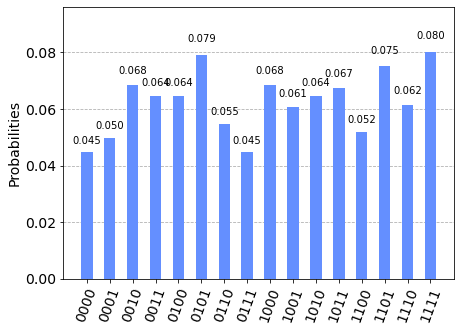

In [13]:
ionqsim_qc=transpile(qc,ionq_backend_sim)



job_ionqsim=ionq_backend_sim.run(ionqsim_qc)


ionqsim_result=job_ionqsim.result()
ionqsim_pros=ionqsim_result.get_counts()
plot_histogram(ionqsim_pros)

In [14]:
ionq_qc=transpile(qc,ionq_backend)
job_ionq=ionq_backend.run(ionq_qc)
ionq_result=job_ionq.result()
ionq_pros=ionq_result.get_counts()
plot_histogram(ionq_pros)

KeyboardInterrupt: 

In [17]:

from qiskit.visualization import plot_bloch_vector
from qiskit.quantum_info import partial_trace
from qiskit.quantum_info import Statevector as sv

qc.remove_final_measurements()
rho=sv(qc)
print(rho)
print(np.trace(rho*rho))




Statevector([ 2.50000000e-01+0.j        ,  2.30969883e-01-0.09567086j,
              1.76776695e-01-0.1767767j ,  9.56708581e-02-0.23096988j,
             -1.53080850e-17-0.25j      , -9.56708581e-02-0.23096988j,
             -1.76776695e-01-0.1767767j , -2.30969883e-01-0.09567086j,
             -2.50000000e-01+0.j        , -2.30969883e-01+0.09567086j,
             -1.76776695e-01+0.1767767j , -9.56708581e-02+0.23096988j,
              1.53080850e-17+0.25j      ,  9.56708581e-02+0.23096988j,
              1.76776695e-01+0.1767767j ,  2.30969883e-01+0.09567086j],
            dims=(2, 2, 2, 2))


QiskitError: 'other is not a number'

$ \rho^2=1 $ means there is no entangled states. So we are going to evaulate bloch sphere of each qubits

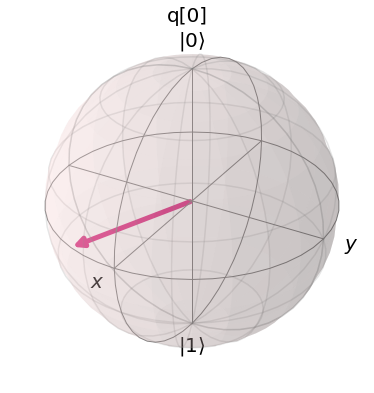

In [31]:

sx=np.array([[0,1], [1,0]])
sy=np.array([[0,-1.0j ], [1.0j,0]])
sz=np.array([[1,0], [0,-1]])


def bloch(i):
    ary=[]
    for j in range(4):
        if j!=i:
            ary.append(j)
    reduced_rho=np.array(partial_trace(sv(qc), ary).data)
    return [np.trace(reduced_rho@sx).real,np.trace(reduced_rho@sy).real,np.trace(reduced_rho@sz).real]
plot_bloch_vector(bloch(0), title="q[0]")


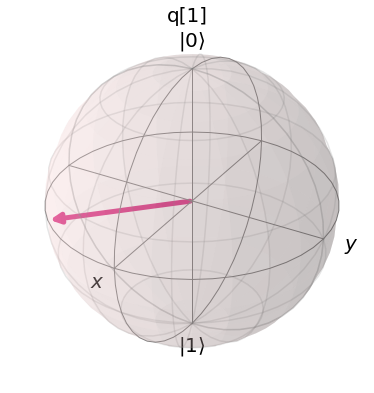

In [32]:
plot_bloch_vector(bloch(1), title="q[1]")


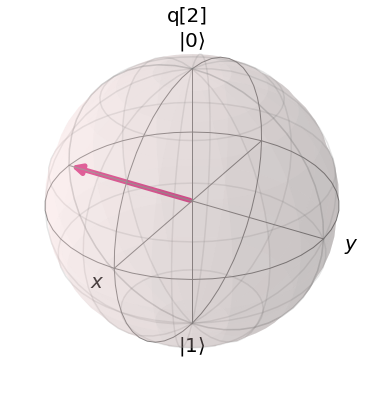

In [33]:
plot_bloch_vector(bloch(2), title="q[2]")


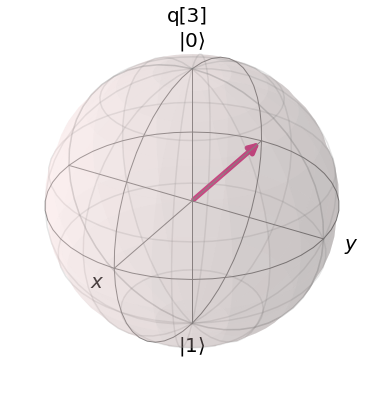

In [34]:
plot_bloch_vector(bloch(3), title="q[3]")

# Task 8

In [35]:
from qiskit.converters import circuit_to_gate
def QPE( n, m, U, psi):
    Ugate=UnitaryGate(U, label='U')
    CUgate=Ugate.control(1)
    qc=QuantumRegister(n, name='qc')
    psic=QuantumRegister(m, name='psi')
    c=ClassicalRegister(n)
    circuit=QuantumCircuit(qc,psic,c)
    circuit.h(qc)
    circuit.initialize(psi, psic[:])
    circuit.barrier()
    for i in range(n):
        for j in range(2**i):
            circuit.append(CUgate,[qc[i],psic[:]])
    qftc = QuantumCircuit(n)
    qft(qftc,n)
    QFT_Gate=circuit_to_gate(qftc,label='QFT')
    IQFT_Gate=QFT_Gate.inverse()
    IQFT_Gate.label= "Inverse_QFT"
    circuit.append(IQFT_Gate,qc[:])
    circuit.measure(qc[:],c[:])
    return circuit
    

The circuit above is the Quantum Phase Estimation for arbitrary qubits and Unitary marix. But, quantum circuit for 10-bit precision is to deep to simulate for any Unitary. 
So we will choose unitary and as RotZ(theta) (1,0) with theta=1 and 
Then we could compress the circuit as below

10


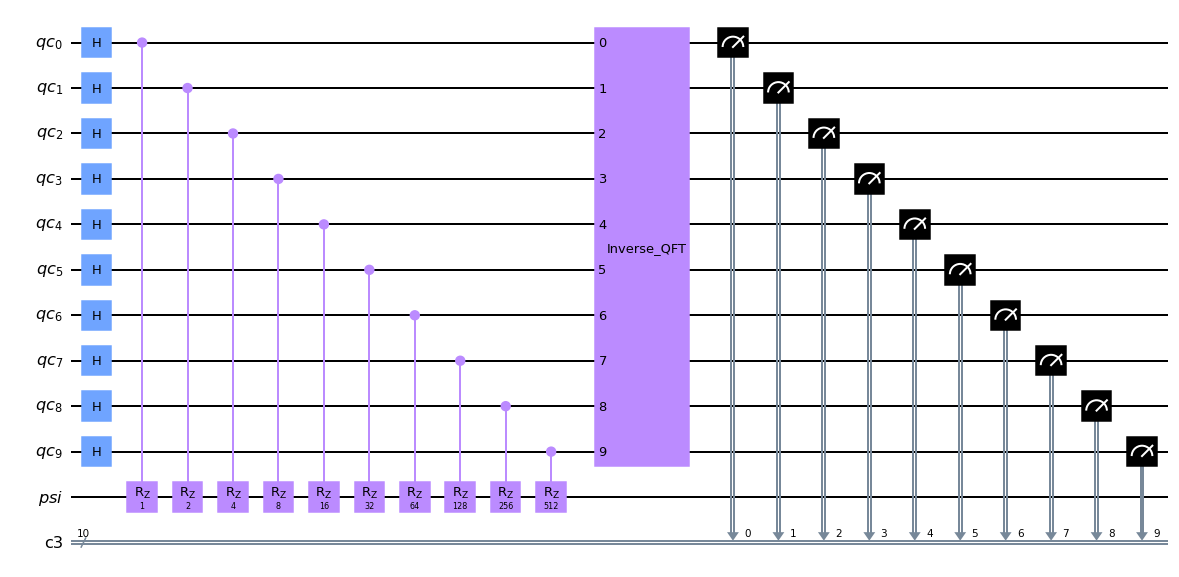

In [46]:
theta=1
QC=QuantumRegister(10, name='qc')
PS=QuantumRegister(1, name='psi')
C=ClassicalRegister(10)
QP=QuantumCircuit(QC,PS,C)
QP.h(QC)
for i in range(10):
    QP.crz(2**i*theta,QC[i],PS)
qftc = QuantumCircuit(10)
qft(qftc,10)
QFT_Gate=circuit_to_gate(qftc,label='QFT')
IQFT_Gate=QFT_Gate.inverse()
IQFT_Gate.label= "Inverse_QFT"
QP.append(IQFT_Gate,QC[:])
QP.measure(QC[:],C[:])
QP.draw('mpl')

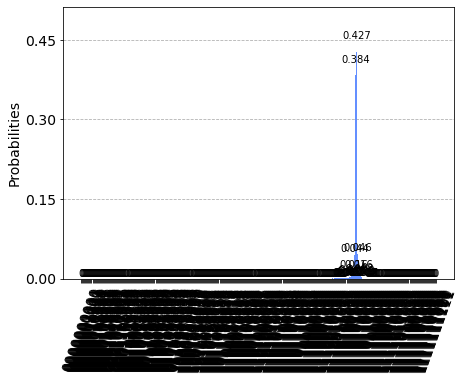

In [77]:
aer_QP=transpile(QP,aer_backend)
shots=100000
QP_obj = assemble(aer_QP, shots=shots)
QP_job = aer_backend.run(QP_obj)
QP_result=QP_job.result()
QP_count = QP_result.get_counts()
plot_histogram(QP_count)


In [78]:
key=[]
count=[]
for i,x in QP_count.items():
    key.append(i)
    count.append(x)
key=np.array(key)
count=np.array(count)
est_phase=key[np.argmax(count)] 
int(est_phase,2)/2**10

0.9208984375

In [75]:
est_phase

'1110101111'

# Task 9
For Task 9 we just could use the function we made before, but then the circuit will be very ineffective due to the deep depth. So we had compressed the circuit shown above.

In [109]:

n=3
m=1
psi=[0,1]


3


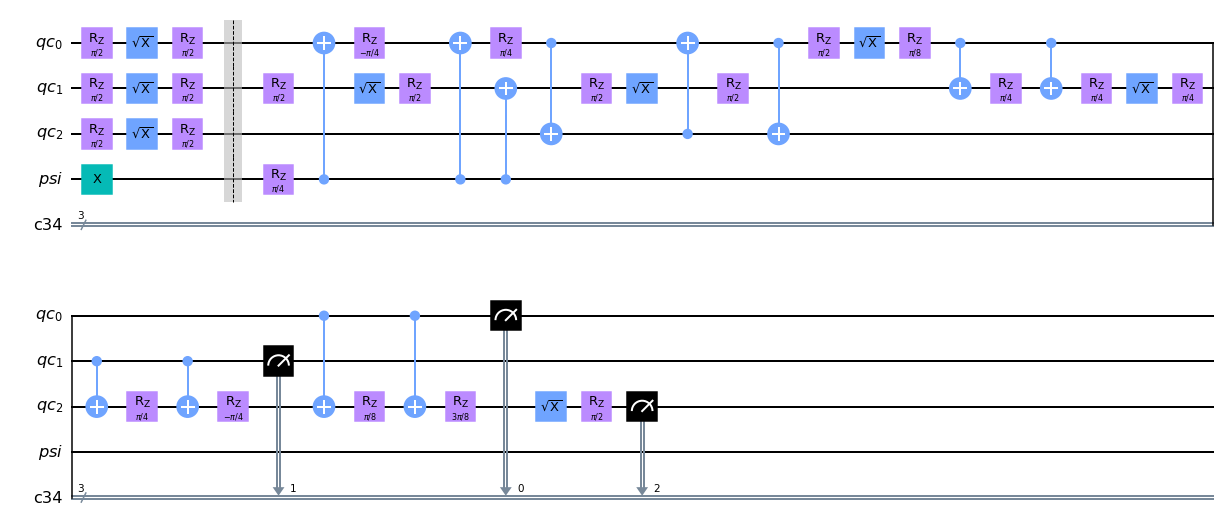

In [131]:
qc=QuantumRegister(n, name='qc')
psic=QuantumRegister(m, name='psi')
c=ClassicalRegister(n)
circuit=QuantumCircuit(qc,psic,c)
circuit.h(qc)
circuit.x(psic[:])
circuit.barrier()
circuit.cp(np.pi/2,psic,qc[0])
circuit.cz(psic, qc[1])
qftc = QuantumCircuit(n)
qft(qftc,n)
QFT_Gate=circuit_to_gate(qftc,label='QFT')
IQFT_Gate=QFT_Gate.inverse()
IQFT_Gate.label= "Inverse_QFT"
circuit.append(IQFT_Gate,qc[:])
circuit.measure(qc[:],c[:])
circuit.draw('mpl')
    

In [112]:
aer_qc2=transpile(circuit,aer_backend)

shots=10000
aer_obj2 = assemble(aer_qc2, shots=shots)
job_aer2 = aer_backend.run(aer_obj2)
aer_result2=job_aer2.result()
aer_pros2 = aer_result2.get_counts()
plot_histogram(aer_pros2)


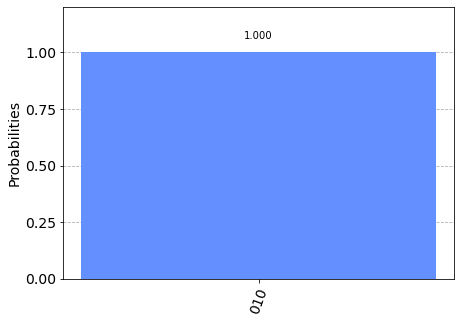

In [114]:
ionqsim_qc2=transpile(circuit,ionq_backend_sim)

job_ionqsim2=ionq_backend_sim.run(ionqsim_qc2)

ionqsim_result2=job_ionqsim2.result()

ionqsim_pros2=ionqsim_result2.get_counts()

plot_histogram(ionqsim_pros2)

In [116]:
ionq_qc2=transpile(circuit,ionq_backend)

job_ionq2=ionq_backend.run(ionq_qc2)

ionq_result2=job_ionq2.result()

ionq_pros2=ionq_result2.get_counts()

plot_histogram(ionq_pros2)

ConnectionError: HTTPSConnectionPool(host='api.ionq.co', port=443): Max retries exceeded with url: /v0.1/jobs/0364b68d-73f5-4947-aa18-81a2ddca0a58 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f570c032e10>: Failed to establish a new connection: [Errno 101] Network is unreachable'))

## Iterative Phase Estimation for better result in real device

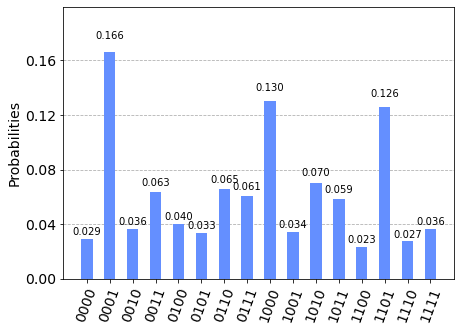

In [ ]:
q = QuantumRegister(2,'q')
c = ClassicalRegister(3,'c')
IPE= QuantumCircuit(2,3)

IPE.h(0)
IPE.x(1) # initialize Psi
IPE.barrier()
IPE.h(0)
IPE.barrier()
IPE.measure(0,0)
IPE.barrier()
IPE.reset(0)
IPE.h(0)
IPE.cz(1,0)
IPE.p(0,-c*np.pi/2)
IPE.h(0)
IPE.barrier()
IPE.measure(0,1)
IPE.barrier()
IPE.reset(0)
IPE.h(0)
IPE.cp(np.pi/2,1,0)
IPE.p(0,-c*np.pi/2)
IPE.h(0)
IPE.barrier()
IPE.measure(0,2)



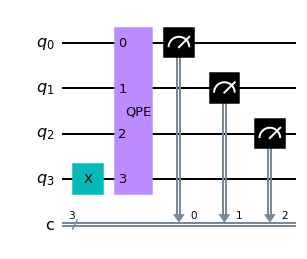

In [91]:
from qiskit.circuit.library import PhaseEstimation
qc=QuantumCircuit(4,3)
qc.x(3)
Ugate=UnitaryGate(U, label='U')
qc.append(PhaseEstimation(3,Ugate),range(4))
qc.measure(range(3),range(3))
qc.draw('mpl')

In [92]:
qc=transpile(qc,aer_backend)


shots=10000
obj = assemble(qc, shots=shots)




job= aer_backend.run(obj)

result=job.result()
count = result.get_counts()


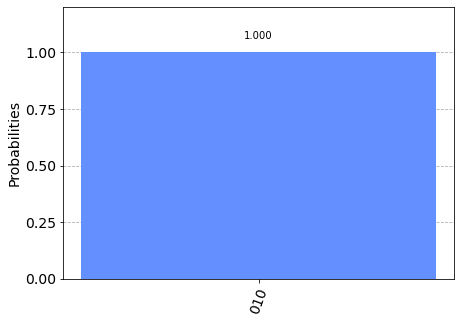

In [93]:
plot_histogram(count)